# UD, Philology and Greek Tragedy

We demonstrate a couple of applications of Universal Dependencies for the philological research on Greek Tragedy. In particular, we leverage the power of a couple of formats and tools to generate alignments between trees and:
* alternative versions
* translations

The technologies we try to apply are:
* [udapi](https://github.com/udapi/udapi-python) to read, manipulate and write UD trees
* [iAligner](http://ialigner.com/index.php) for token alignment of paralel versions
* udapi again to write a nice HTML serialization of our paired treebanks 

## Read the data

We start with sample data. We presuppose that the following treebanks are available in UD format:
* a standard treebank of a Greek tragedy (you can use my trees from [katholou]())
* an alternative version of the same text

If you need to quickly generate UD treebank for testing purporses, you can use the pre-trained models and the REST-API for [udpipe](https://lindat.mff.cuni.cz/services/udpipe/)

In this folder, you'll find one short sentence from Aeschylus, *Agamemnon* 412, in two versions: the original AGLDT treebank and a version (also treebanked by myself) from A.H. Sommerstein's new Loeb edition of Aeschylus  

In [1]:
from udapi.core.document import Document
from udapi.block.write.html import Html as HtmlWriter

In [2]:
doc = Document()
doc.load_conllu('data/ag_412_tb.conllu')

In [3]:
tree = doc.bundles[0].get_tree()

In [4]:
print(tree.text)

πάρεστι σιγὰς ἀτίμους ἀλοιδόρους ἄλγιστ' ἀφημένων ἰδεῖν.


In [5]:
tree.draw()

# sent_id = 161
# text = πάρεστι σιγὰς ἀτίμους ἀλοιδόρους ἄλγιστ' ἀφημένων ἰδεῖν.
─┮
 ╰─┮ πάρεστι VERB root
   │ ╭─┮ σιγὰς NOUN obj
   │ │ ┡─╼ ἀτίμους ADJ amod
   │ │ ┡─╼ ἀλοιδόρους ADJ amod
   │ │ │ ╭─╼ ἄλγιστ' ADJ obl
   │ │ ╰─┶ ἀφημένων VERB nmod
   ┡─┶ ἰδεῖν VERB csubj
   ╰─╼ . PUNCT punct



Now we:
* load the Sommerstein version
* then we create a new document with the two treebanks paired as two zones of a single bundle 

In [6]:
som = Document()
som.load_conllu('data/ag_412_Sommerstein.conllu')

In [7]:
newdoc = Document()
bund = newdoc.create_bundle()
tb = bund.add_tree(tree)
tb.zone = 'grc_tb'
lb = bund.add_tree(som.bundles[0].trees[0])
lb.zone = 'grc_lb'

Now the document `newdoc` has a single bundle (i.e. sentence) with 2 trees

## Align the tokens 

As it can be seen, the text of the two zones of the bundle is slightly different:

In [8]:
for tree in bund.trees:
    print(tree.text)

πάρεστι σιγὰς ἀτίμους ἀλοιδόρους ἄλγιστ' ἀφημένων ἰδεῖν.
πάρεστι σιγὰς ἀτίμους ἀλοιδόρους ἀλιστοὺς ἀφειμένων ἰδεῖν.


We ca use `iAligner` to align the tokens of the versions. I know, it looks like an overkill in this case, but obviously not everything is so charmingly easy...

In [9]:
from iAlignment.iAligner import iAligner
from iAlignment.Viewer import Viewer

In [10]:
aligner = iAligner()

As UD trees are already tokenized, we feed the tokens of the two sentences directly

In [11]:
aligner.sentence1.tokens = [tok.form for tok in tb.descendants]
aligner.sentence2.tokens = [tok.form for tok in lb.descendants]

In [12]:
aligner.initialization()
aligner.fillMatrix()
aligner.getOptimalAlignment()

In [13]:
alignment = aligner.optimal_alignment
alignment

[{'sentence1': 'πάρεστι',
  'sentence2': 'πάρεστι',
  'relation': 'Aligned-complete'},
 {'sentence1': 'σιγὰς', 'sentence2': 'σιγὰς', 'relation': 'Aligned-complete'},
 {'sentence1': 'ἀτίμους',
  'sentence2': 'ἀτίμους',
  'relation': 'Aligned-complete'},
 {'sentence1': 'ἀλοιδόρους',
  'sentence2': 'ἀλοιδόρους',
  'relation': 'Aligned-complete'},
 {'sentence1': "ἄλγιστ'", 'sentence2': 'ἀλιστοὺς', 'relation': 'notAligned'},
 {'sentence1': 'ἀφημένων', 'sentence2': 'ἀφειμένων', 'relation': 'notAligned'},
 {'sentence1': 'ἰδεῖν', 'sentence2': 'ἰδεῖν', 'relation': 'Aligned-complete'},
 {'sentence1': '.', 'sentence2': '.', 'relation': 'Aligned-complete'}]

We can visualize it live, but first we must embed some [CSS](http://ialigner.com/assets/css/style.css) from iAligner!

In [14]:
viewer = Viewer()
h_al = viewer.alignmentToHtmlCode(alignment)

In [15]:
css_str = '''<style>.notAligned{
    background-color:#E84A3F;
    color:#FFF;
}
.aligned{
    background-color:#BDB76B
}
.Aligned-complete{
    background-color:#318203;
    color:#FFF;
}
.Aligned-removedNonAlphanumeric{
    background-color:#6BC934;
    color:#FFF;
}
</style>'''

In [28]:
from IPython.core.display import display, HTML, SVG
display(HTML(css_str + h_al))

πάρεστι,σιγὰς,ἀτίμους,ἀλοιδόρους,ἄλγιστ',ἀφημένων,ἰδεῖν,.
πάρεστι,σιγὰς,ἀτίμους,ἀλοιδόρους,ἀλιστοὺς,ἀφειμένων,ἰδεῖν,.


## Write the html

In [17]:
writer = HtmlWriter(files='data/ag_412.html')

In [ ]:
writer.apply_on_document(newdoc)

Udapi `Html writer` uses [this](https://github.com/ufal/js-treex-view) JavaScript library, which is probably not under strict maintainance or development. Basically, the TB data are serialized to JSON, added to the html page, and then the js library renders the JSON on the fly.

Perhaps it's possible to improve the JS library or to add some information to the JSON data dump, but JavaScript is not really my cup of tea...

In [43]:
from IPython.display import IFrame

IFrame(src='./data/ag_412.html', width=700, height=600)

The amazing thing of this out-of-the box solution is that it is possible to **higlight words simultaneously in both trees by hovering on them** and it performs a sort of automatic alignment that, at least for a simple sentence like this one, works very effectively!

Go ahead and `click on ἀφημένων` in the sentence above the trees! See that?

## Translation alignment

The first Italian translation I could lay my hands on (E. Romagnoli, 1922) translates this sentence as:

```
Vedi l'obbrobrio muto, nella doglia acutissima in disparte seduto.
```

I ran UDPipe 2 on that, and this is the result

In [18]:
romagnoli_str = '''# generator = UDPipe 2, https://lindat.mff.cuni.cz/services/udpipe
# udpipe_model = italian-isdt-ud-2.6-200830
# udpipe_model_licence = CC BY-NC-SA
# newdoc
# newpar
# sent_id = 1
# text = Vedi l'obbrobrio muto, nella doglia acutissima in disparte seduto.
1	Vedi	vedere	VERB	V	Mood=Imp|Number=Sing|Person=2|Tense=Pres|VerbForm=Fin	0	root	_	TokenRange=0:4
2	l'	il	DET	RD	Definite=Def|Number=Sing|PronType=Art	3	det	_	SpaceAfter=No|TokenRange=5:7
3	obbrobrio	obbrobrio	NOUN	S	Gender=Masc|Number=Sing	1	obj	_	TokenRange=7:16
4	muto	muto	ADJ	A	Gender=Masc|Number=Sing	3	amod	_	SpaceAfter=No|TokenRange=17:21
5	,	,	PUNCT	FF	_	1	punct	_	TokenRange=21:22
6-7	nella	_	_	_	_	_	_	_	TokenRange=23:28
6	in	in	ADP	E	_	8	case	_	_
7	la	il	DET	RD	Definite=Def|Gender=Fem|Number=Sing|PronType=Art	8	det	_	_
8	doglia	doglia	NOUN	S	Gender=Fem|Number=Sing	1	obl	_	TokenRange=29:35
9	acutissima	acuto	ADJ	A	Degree=Abs|Gender=Fem|Number=Sing	8	amod	_	TokenRange=36:46
10	in	in	ADP	E	_	11	case	_	TokenRange=47:49
11	disparte	disparte	NOUN	S	Gender=Masc|Number=Sing	8	nmod	_	TokenRange=50:58
12	seduto	seduto	ADJ	A	Gender=Masc|Number=Sing	11	amod	_	SpaceAfter=No|TokenRange=59:65
13	.	.	PUNCT	FS	_	1	punct	_	SpaceAfter=No|TokenRange=65:66

'''

In [19]:
trdoc = Document()
trdoc.from_conllu_string(romagnoli_str)
#trbund = trdoc.create_bundle()
#trbund.add_tree(tb)

In [20]:
trdoc.bundles[0].get_tree().draw()

# sent_id = 1
# text = Vedi l'obbrobrio muto, nella doglia acutissima in disparte seduto.
─┮
 ╰─┮ Vedi VERB root
   │ ╭─╼ l' DET det
   ┡─┾ obbrobrio NOUN obj
   │ ╰─╼ muto ADJ amod
   ┡─╼ , PUNCT punct
   │ ╭─╼ in ADP case
   │ ┢─╼ la DET det
   ┡─┾ doglia NOUN obl
   │ ┡─╼ acutissima ADJ amod
   │ │ ╭─╼ in ADP case
   │ ╰─┾ disparte NOUN nmod
   │   ╰─╼ seduto ADJ amod
   ╰─╼ . PUNCT punct



By the way, I'm not goin to tamper with the automatic parsing, but UDPipe got the phrase *in disparte seduto* wrong. Perhaps, the poetic word order confused the model; in standard Italian you would say: *seduto in disparte*

In [21]:
ittr = trdoc.bundles[0].get_tree()
ittr.zone = 'it_rom'

In [22]:
trbund = trdoc.bundles[0]
trbund.add_tree(tb)

We could export the whole "package" to an HTML visualization like before, but in this case, with extra-language alignment, it doesn't work as effectively as with intra-language parallel treees... What we can do instead is to export everything in the Treex XML fomat (a custom serialization for multi-treebank data used by the Prague Dependency Treebak). This format supports alignments from treebank of different zones; we could use an editor like [TrEd](https://universaldependencies.org/tools.html#tred) to build and visualize the alignment.

**NOTE**: unfortunately, TrEd would need the `Treex` Perl framework to be able to open the .treex file and work with it, which is a gigantic pain in the b*** to [install](https://ufal.mff.cuni.cz/treex/install.html). Don't do it at home! I'll do it for you: you can buy me a beer next time we see each other...

In [ ]:
# this would be to write everything to an HTML file
tr_writer = Html(files='data/ag_412_transl.html')
tr_writer.apply_on_document(trdoc)

In [ ]:
# this is for Treex
from udapi.block.write.treex import Treex

treex = Treex
treex_writer = Treex(files='data/ag412_transl.treex')
treex_writer.apply_on_document(trdoc)

I have manually annotated the alignment between text and Italian translation and exported the results as an SVG image. Here is what we get:

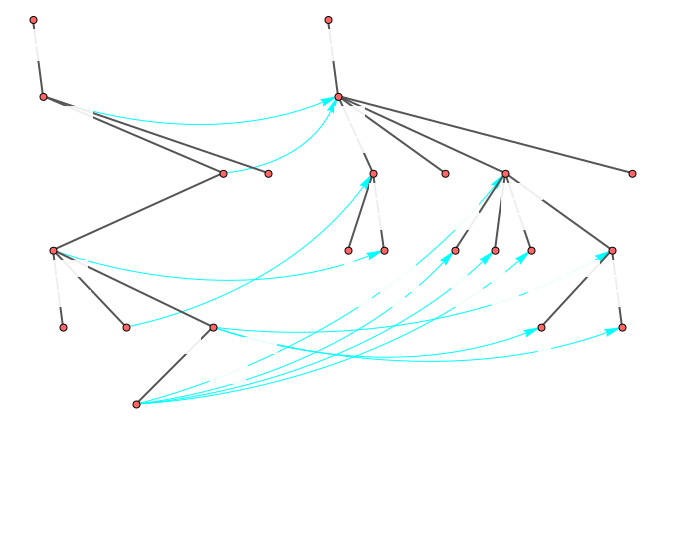

In [29]:
display(SVG('data/ag_transl.svg'))

That's not bad at all! It would be even better if we could get the same alignment arrow to toggle even in the HTML export... But unfortunately the JS library [seems](https://github.com/ufal/js-treex-view/issues/1) unable to handle non-dependency relations between nodes, and the package is not maintained anymore. More savy JS programmers may find cool solutions... ;-)